In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [15]:
# read the data
data_df = pd.read_csv('./storage/datasets/credit/cs-training.csv')
data_df = data_df.dropna(axis=0, how='any')  # drop rows with missing values


In [16]:
print(f"Shape: {data_df.shape}")
print(f"Colunas: {data_df.columns.tolist()}")
print(f"Tipos: {data_df.dtypes}")
print(f"Missing values: {data_df.isnull().sum()}")

Shape: (120269, 12)
Colunas: ['Unnamed: 0', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
Tipos: Unnamed: 0                                int64
SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object
Missing values: Unnamed: 0                              0
SeriousD

In [ ]:
def tratar_monthly_income_com_mediana_e_log(df, col='MonthlyIncome'):
    """
    Trata MonthlyIncome: preenche missing com mediana, depois aplica log
    """
    
    df_tratado = df.copy()
    
    print(f"🔍 TRATAMENTO ESPECÍFICO: {col}")
    print("=" * 50)
    
    # 1. ANÁLISE INICIAL
    print(f"📊 Dados originais:")
    print(f"   Shape: {df[col].shape}")
    print(f"   Missing: {df[col].isnull().sum()} ({df[col].isnull().mean()*100:.1f}%)")
    print(f"   Min: {df[col].min()}")
    print(f"   Max: {df[col].max()}")
    print(f"   Média: {df[col].mean():.2f}")
    print(f"   Mediana: {df[col].median():.2f}")
    print(f"   Zeros: {(df[col] == 0).sum()}")
    print(f"   Negativos: {(df[col] < 0).sum()}")
    print(f"   Assimetria original: {df[col].skew():.2f}")
    
    # 2. PREENCHER MISSING COM MEDIANA
    mediana_original = df[col].median()
    print(f"\n💉 Preenchendo missing values:")
    print(f"   Mediana para preenchimento: {mediana_original:.2f}")
    
    df_tratado[col] = df[col].fillna(mediana_original)
    
    print(f"   ✅ Missing após preenchimento: {df_tratado[col].isnull().sum()}")
    
    # 3. VERIFICAR SE PODE APLICAR LOG
    min_value = df_tratado[col].min()
    print(f"\n🔬 Verificação para LOG:")
    print(f"   Valor mínimo: {min_value}")
    
    if min_value >= 0:
        print("   ✅ Todos valores >= 0, pode aplicar log")
        
        # 4. APLICAR TRANSFORMAÇÃO LOG
        col_log = f"{col}_log"
        df_tratado[col_log] = np.log1p(df_tratado[col])
        
        # 5. COMPARAR ASSIMETRIAS
        skew_original = df_tratado[col].skew()
        skew_log = df_tratado[col_log].skew()
        
        print(f"\n📈 Resultado da transformação:")
        print(f"   Assimetria original: {skew_original:.2f}")
        print(f"   Assimetria após log: {skew_log:.2f}")
        print(f"   Melhoria: {abs(skew_original) - abs(skew_log):.2f}")
        
        # 6. DECISÃO: MANTER OU DESCARTAR LOG
        if abs(skew_log) < abs(skew_original):
            # Log melhorou, substituir
            df_tratado[col] = df_tratado[col_log]
            df_tratado.drop(col_log, axis=1, inplace=True)
            print(f"   ✅ LOG MANTIDO (melhorou assimetria)")
            transformacao_final = f"Mediana + Log1p"
        else:
            # Log piorou, manter original
            df_tratado.drop(col_log, axis=1, inplace=True)
            print(f"   ❌ LOG DESCARTADO (piorou assimetria)")
            transformacao_final = f"Apenas mediana"
        
        # 7. VISUALIZAÇÃO COMPARATIVA
        print(f"\n📊 Criando visualização comparativa...")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Tratamento de {col}', fontsize=16, fontweight='bold')
        
        # Original (com missing)
        original_clean = df[col].dropna()
        axes[0, 0].hist(original_clean, bins=50, alpha=0.7, color='red', edgecolor='black')
        axes[0, 0].set_title(f'Original (Skew: {original_clean.skew():.2f})')
        axes[0, 0].set_xlabel('Valor Original')
        axes[0, 0].set_ylabel('Frequência')
        
        # Após preencher com mediana
        axes[0, 1].hist(df_tratado[col], bins=50, alpha=0.7, color='blue', edgecolor='black')
        axes[0, 1].set_title(f'Após Mediana (Skew: {df_tratado[col].skew():.2f})')
        axes[0, 1].set_xlabel('Após Preenchimento')
        axes[0, 1].set_ylabel('Frequência')
        
        # Log transformation (se aplicada)
        if transformacao_final == "Mediana + Log1p":
            axes[1, 0].hist(df_tratado[col], bins=50, alpha=0.7, color='green', edgecolor='black')
            axes[1, 0].set_title(f'Final: Log Applied (Skew: {df_tratado[col].skew():.2f})')
            axes[1, 0].set_xlabel('Log Transformed')
        else:
            # Mostrar como seria o log (para comparação)
            temp_log = np.log1p(df_tratado[col])
            axes[1, 0].hist(temp_log, bins=50, alpha=0.7, color='orange', edgecolor='black')
            axes[1, 0].set_title(f'Log (não usado) (Skew: {temp_log.skew():.2f})')
            axes[1, 0].set_xlabel('Log (descartado)')
        
        # Boxplot final
        axes[1, 1].boxplot(df_tratado[col])
        axes[1, 1].set_title(f'Boxplot Final')
        axes[1, 1].set_ylabel('Valores Finais')
        
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"   ❌ Valores negativos detectados ({min_value})")
        print(f"   💡 Aplicando winsorização em vez de log")
        
        from scipy.stats import mstats
        df_tratado[col] = mstats.winsorize(df_tratado[col], limits=[0.05, 0.05])
        transformacao_final = "Mediana + Winsorização"
    
    # 8. RESUMO FINAL
    print(f"\n✅ RESUMO FINAL:")
    print(f"   Transformação aplicada: {transformacao_final}")
    print(f"   Assimetria final: {df_tratado[col].skew():.2f}")
    print(f"   Missing values finais: {df_tratado[col].isnull().sum()}")
    print(f"   Shape final: {df_tratado[col].shape}")
    
    # Classificar resultado final
    final_skew = abs(df_tratado[col].skew())
    if final_skew <= 0.5:
        status = "✅ EXCELENTE (aproximadamente simétrica)"
    elif final_skew <= 1.0:
        status = "🟢 BOA (moderadamente assimétrica)"
    elif final_skew <= 2.0:
        status = "🟡 ACEITÁVEL (assimétrica)"
    else:
        status = "🚨 AINDA PROBLEMÁTICA (extremamente assimétrica)"
    
    print(f"   Status final: {status}")
    
    return df_tratado

# APLICAR NO SEU DATASET
print("🚀 Aplicando tratamento em MonthlyIncome...")
df_income_tratado = tratar_monthly_income_com_mediana_e_log(data_df, 'MonthlyIncome')

# Verificar resultado
print(f"\n🎯 VERIFICAÇÃO FINAL:")
print(f"MonthlyIncome - Assimetria: {df_income_tratado['MonthlyIncome'].skew():.2f}")

Removendo colunas desnecessárias: ['Unnamed: 0']

🔍 Analisando RevolvingUtilizationOfUnsecuredLines:
   Assimetria original: 102.52
   Min: 0.00
   Max: 50708.00
   Zeros: 7871
   Negativos: 0
   NaNs: 0
   ✅ Log aplicado: 102.52 → 11.75
   ✅ Transformação mantida (melhoria)

🔍 Analisando NumberOfTime30-59DaysPastDueNotWorse:
   Assimetria original: 26.71
   Min: 0.00
   Max: 98.00
   Zeros: 99970
   Negativos: 0
   NaNs: 0
   ✅ Log aplicado: 26.71 → 3.69
   ✅ Transformação mantida (melhoria)

🔍 Analisando DebtRatio:
   Assimetria original: 72.87
   Min: 0.00
   Max: 61106.50
   Zeros: 2491
   Negativos: 0
   NaNs: 0
   ✅ Log aplicado: 72.87 → 7.23
   ✅ Transformação mantida (melhoria)

🔍 Analisando MonthlyIncome:
   Assimetria original: 114.04
   Min: 0.00
   Max: 3008750.00
   Zeros: 1634
   Negativos: 0
   NaNs: 0
   ✅ Log aplicado: 114.04 → -4.36
   ✅ Transformação mantida (melhoria)

🔍 Analisando NumberOfTimes90DaysLate:
   Assimetria original: 27.63
   Min: 0.00
   Max: 98.00
   

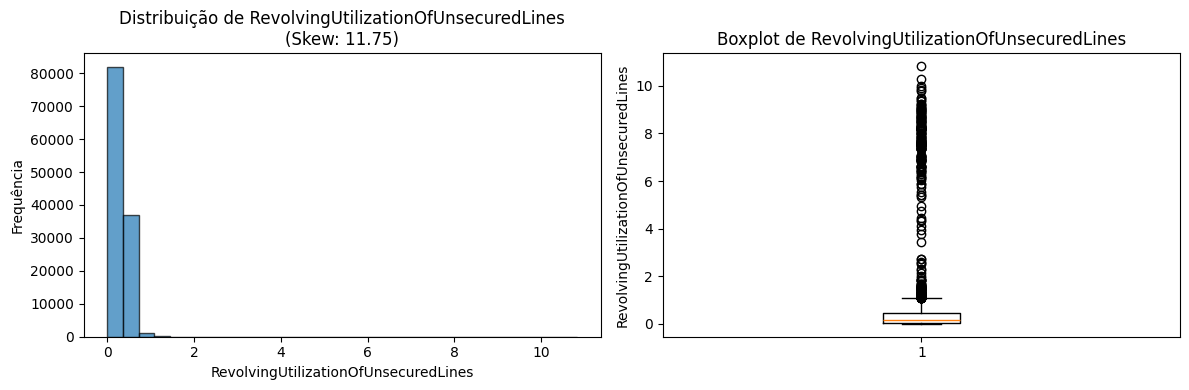


Variável: age
----------------------------------------
Média: 51.29
Mediana: 51.00
Desvio Padrão: 14.43
Assimetria: 0.23
Curtose: -0.47
Missing Values: 0 (0.0%)
Interpretação: ✅ Aproximadamente simétrica


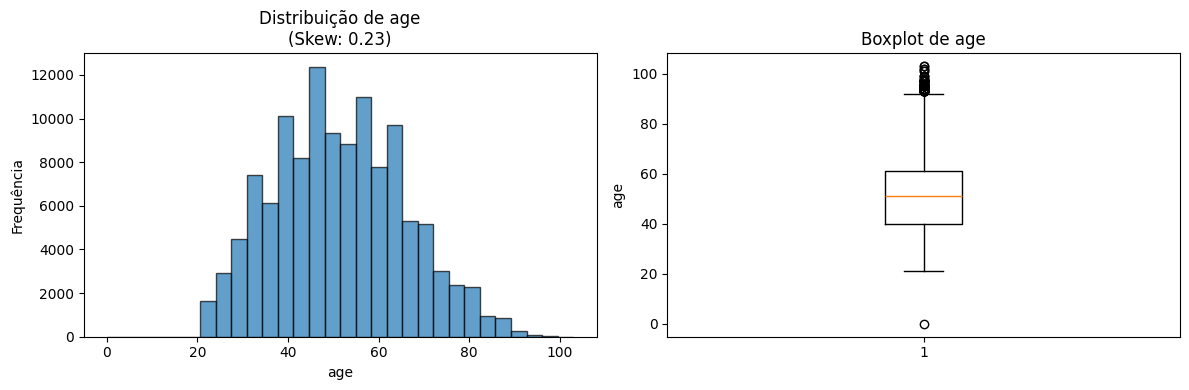


Variável: NumberOfTime30-59DaysPastDueNotWorse
----------------------------------------
Média: 0.15
Mediana: 0.00
Desvio Padrão: 0.39
Assimetria: 3.69
Curtose: 24.33
Missing Values: 0 (0.0%)
Interpretação: 🚨 Extremamente assimétrica


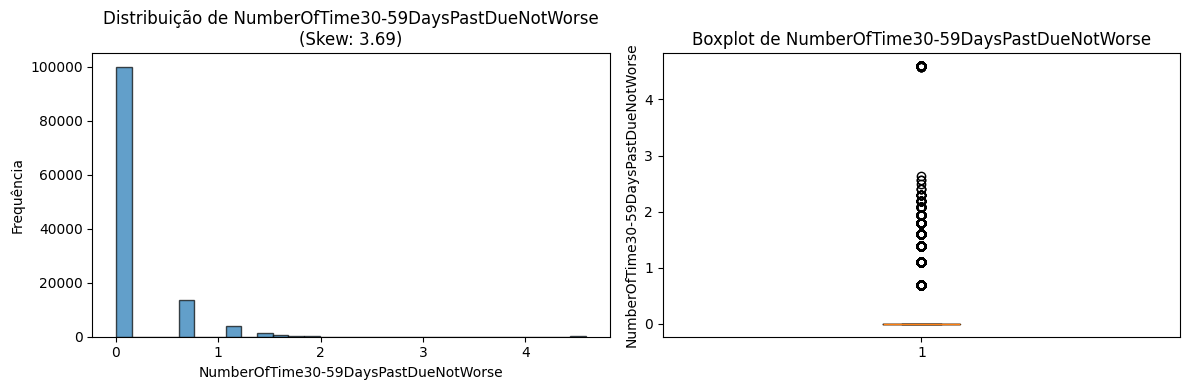


Variável: DebtRatio
----------------------------------------
Média: 0.39
Mediana: 0.26
Desvio Padrão: 0.85
Assimetria: 7.23
Curtose: 56.03
Missing Values: 0 (0.0%)
Interpretação: 🚨 Extremamente assimétrica


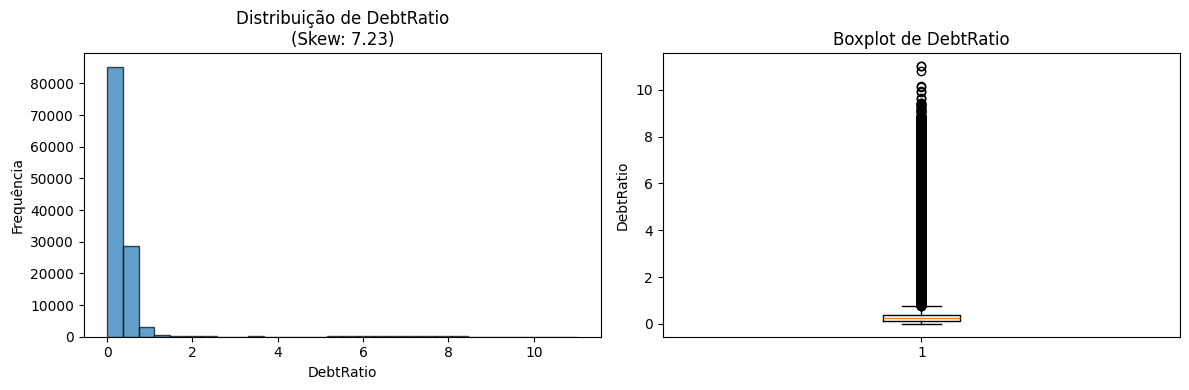


Variável: MonthlyIncome
----------------------------------------
Média: 8.41
Mediana: 8.59
Desvio Padrão: 1.33
Assimetria: -4.36
Curtose: 24.68
Missing Values: 0 (0.0%)
Interpretação: 🚨 Extremamente assimétrica


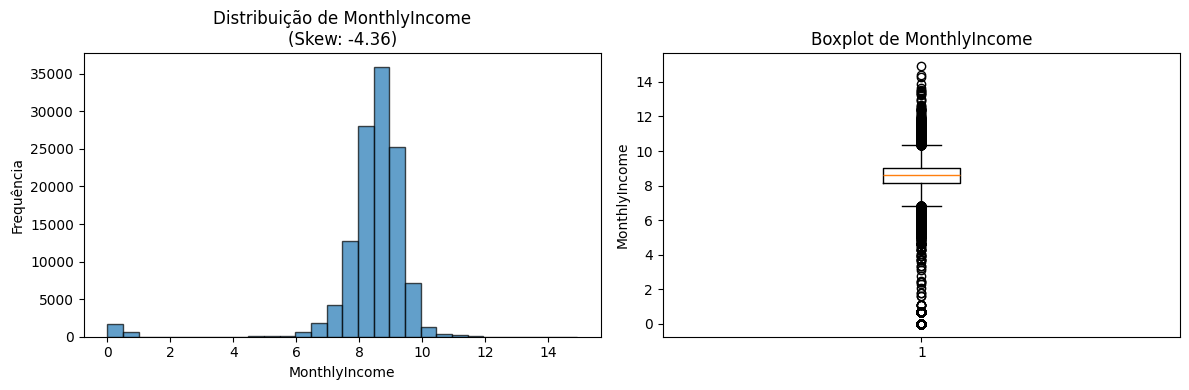


Variável: NumberOfOpenCreditLinesAndLoans
----------------------------------------
Média: 8.76
Mediana: 8.00
Desvio Padrão: 5.17
Assimetria: 1.22
Curtose: 3.23
Missing Values: 0 (0.0%)
Interpretação: 🟠 Assimétrica


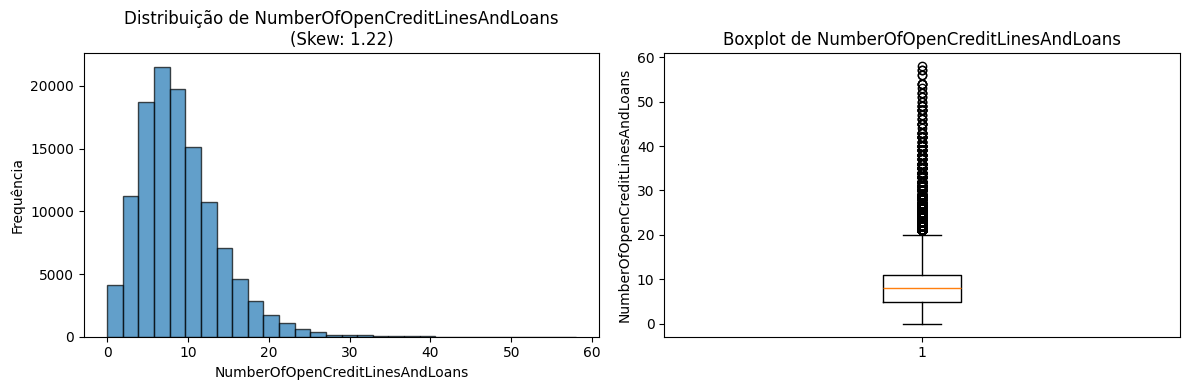


Variável: NumberOfTimes90DaysLate
----------------------------------------
Média: 0.06
Mediana: 0.00
Desvio Padrão: 0.27
Assimetria: 8.32
Curtose: 104.36
Missing Values: 0 (0.0%)
Interpretação: 🚨 Extremamente assimétrica


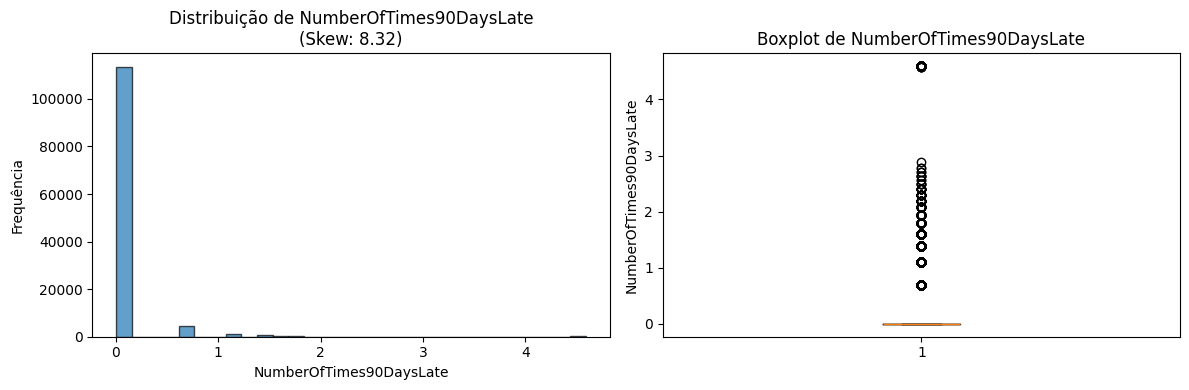


Variável: NumberRealEstateLoansOrLines
----------------------------------------
Média: 0.59
Mediana: 0.69
Desvio Padrão: 0.50
Assimetria: 0.20
Curtose: -0.73
Missing Values: 0 (0.0%)
Interpretação: ✅ Aproximadamente simétrica


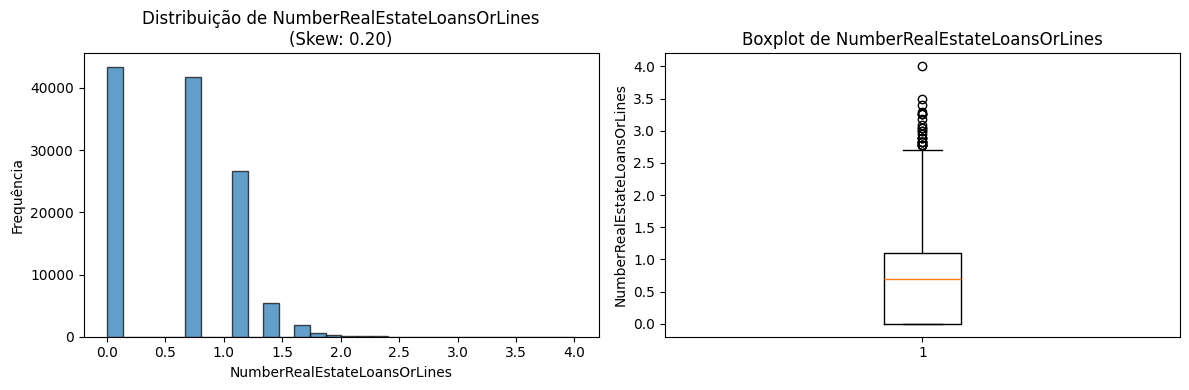


Variável: NumberOfTime60-89DaysPastDueNotWorse
----------------------------------------
Média: 0.05
Mediana: 0.00
Desvio Padrão: 0.24
Assimetria: 9.97
Curtose: 152.87
Missing Values: 0 (0.0%)
Interpretação: 🚨 Extremamente assimétrica


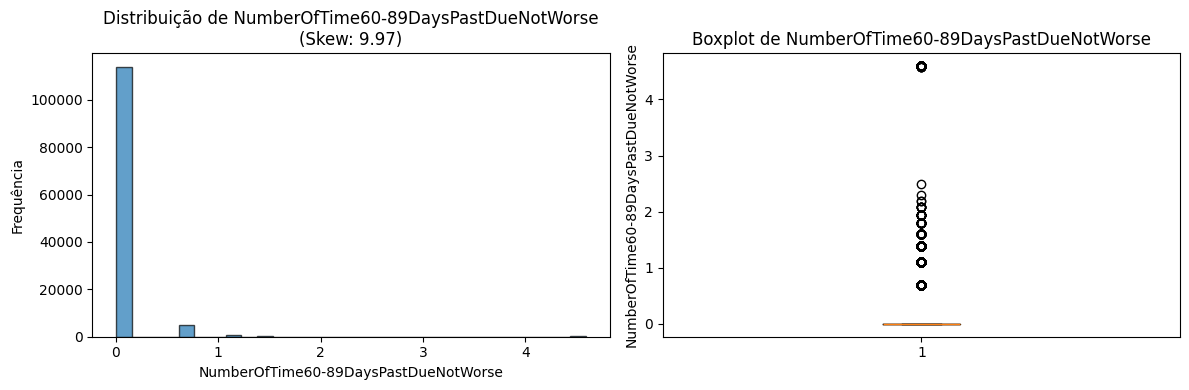


Variável: NumberOfDependents
----------------------------------------
Média: 0.85
Mediana: 0.00
Desvio Padrão: 1.15
Assimetria: 1.43
Curtose: 2.54
Missing Values: 0 (0.0%)
Interpretação: 🟠 Assimétrica


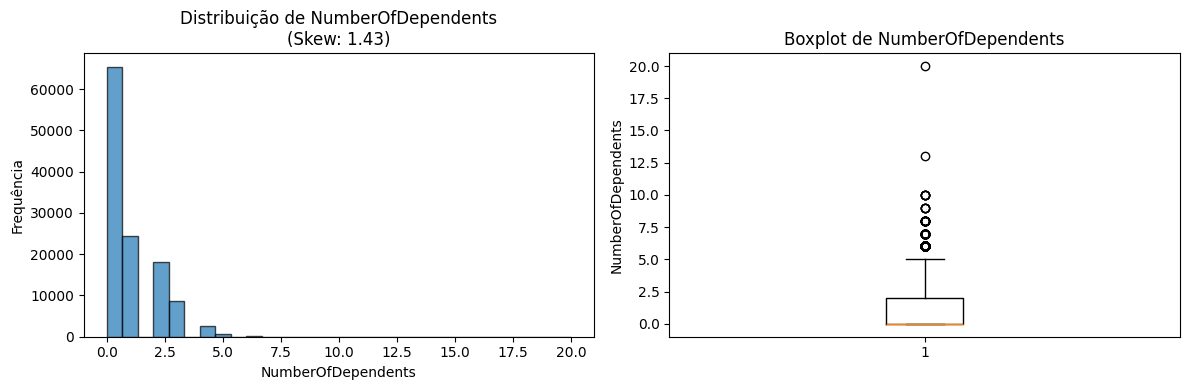

In [ ]:
def analise_univariada_corrigida(df, target_col='SeriousDlqin2yrs'):
    """
    Análise univariada com transformação logarítmica corrigida
    """
    
    # Criar cópia do dataframe para não alterar o original
    df_clean = df.copy()
    
    # Remover colunas desnecessárias
    cols_to_remove = []
    for col in df_clean.columns:
        if 'unnamed' in col.lower() or 'index' in col.lower() or col.lower() == 'id':
            cols_to_remove.append(col)
    
    if cols_to_remove:
        print(f"Removendo colunas desnecessárias: {cols_to_remove}")
        df_clean = df_clean.drop(columns=cols_to_remove)

    # aplicar tratar_monthly_income_com_mediana_e_log
    if 'MonthlyIncome' in df_clean.columns:
        df_clean = tratar_monthly_income_com_mediana_e_log(df_clean, 'MonthlyIncome')
    else:
        print("Coluna 'MonthlyIncome' não encontrada, pulando tratamento específico.")
    # Separar variáveis numéricas e categóricas
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    
    categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"\n=== ANÁLISE UNIVARIADA ===")
    print(f"Variáveis numéricas: {len(numeric_cols)}")
    print(f"Variáveis categóricas: {len(categorical_cols)}")
    print(f"Target: {target_col}")
    print("-" * 60)
    
    # Análise de variáveis numéricas
    for col in numeric_cols:
        print(f"\nVariável: {col}")
        print("-" * 40)
        
        # Verificar se dados são válidos
        if df_clean[col].isnull().all():
            print("❌ Todos os valores são NaN - pulando análise")
            continue
        
        # Estatísticas descritivas
        stats = df_clean[col].describe()
        skewness = df_clean[col].skew()
        kurtosis = df_clean[col].kurtosis()
        
        print(f"Média: {stats['mean']:.2f}")
        print(f"Mediana: {stats['50%']:.2f}")
        print(f"Desvio Padrão: {stats['std']:.2f}")
        print(f"Assimetria: {skewness:.2f}")
        print(f"Curtose: {kurtosis:.2f}")
        print(f"Missing Values: {df_clean[col].isnull().sum()} ({df_clean[col].isnull().mean()*100:.1f}%)")
        
        # Interpretação da assimetria
        if abs(skewness) <= 0.5:
            interpretacao = "✅ Aproximadamente simétrica"
        elif abs(skewness) <= 1.0:
            interpretacao = "🟡 Moderadamente assimétrica"
        elif abs(skewness) <= 2.0:
            interpretacao = "🟠 Assimétrica"
        else:
            interpretacao = "🚨 Extremamente assimétrica"
        
        print(f"Interpretação: {interpretacao}")
        
        # Visualização
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Histograma
        valid_data = df_clean[col].dropna()
        if len(valid_data) > 0:
            axes[0].hist(valid_data, bins=30, alpha=0.7, edgecolor='black')
            axes[0].set_title(f'Distribuição de {col}\n(Skew: {skewness:.2f})')
            axes[0].set_xlabel(col)
            axes[0].set_ylabel('Frequência')
            
            # Boxplot
            axes[1].boxplot(valid_data)
            axes[1].set_title(f'Boxplot de {col}')
            axes[1].set_ylabel(col)
        
        plt.tight_layout()
        plt.show()
    
    return df_clean

# Usar a versão corrigida
df_analisado = analise_univariada_corrigida(data_df)